In [1]:
import pandas as pd
from pathlib import Path
import h3
import folium
from geojson import Feature, Point, FeatureCollection
import json
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import ast
pd.options.mode.copy_on_write = True 
from functools import reduce

## Create JSON of subspecies

In [267]:
# Load eBird taxonomy
taxonomy = pd.read_csv("/Users/tessa/Code/scratchpad/subspecies_plotter/eBird_taxonomy_v2024.csv")
taxonomy.head()

,TAXON_ORDER,CATEGORY,SPECIES_CODE,TAXON_CONCEPT_ID,PRIMARY_COM_NAME,SCI_NAME,ORDER,FAMILY,SPECIES_GROUP,REPORT_AS
0,2,species,ostric2,NaN,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,7,species,ostric3,NaN,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
2,8,slash,y00934,NaN,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
3,10,species,soucas1,NaN,Southern Cassowary,Casuarius casuarius,Casuariiformes,Casuariidae (Cassowaries and Emu),Cassowaries and Emu,NaN
4,11,species,dwacas1,NaN,Dwarf Cassowary,Casuarius bennetti,Casuariiformes,Casuariidae (Cassowaries and Emu),Cassowaries and Emu,NaN


In [269]:
# What categories are there in the taxonomy?
taxonomy.CATEGORY.unique()


array(['species', 'slash', 'issf', 'hybrid', 'spuh', 'domestic', 'form',
       'intergrade'], dtype=object)

In [271]:
# How many species are there?
species = taxonomy[taxonomy.CATEGORY == 'species']
len(species)


11145

In [273]:
# How many infraspecific entries are there?
infrasp_categories = ['issf', 'form', 'intergrade']
infraspp = taxonomy[taxonomy.CATEGORY.isin(infrasp_categories)]
len(infraspp)

3843

Outdated: Clements taxonomy

In [274]:
# Load Clements taxonomy
# taxonomy = pd.read_csv("/Users/tessa/Code/scratchpad/subspecies_plotter/Clements-v2024-October-2024-rev.csv")
# taxonomy.head()

# What categories are there in the taxonomy?
# taxonomy.category.unique()

# How many species are there?
# species = taxonomy[taxonomy.category == 'species']
# len(species)

# How many infraspecific entries are there?
#infrasp_categories = ['subspecies', 'group (monotypic)', 'group (polytypic)', 'form']
#infraspp = taxonomy[taxonomy.category.isin(infrasp_categories)]
#len(infraspp)

In [275]:
species

,TAXON_ORDER,CATEGORY,SPECIES_CODE,TAXON_CONCEPT_ID,PRIMARY_COM_NAME,SCI_NAME,ORDER,FAMILY,SPECIES_GROUP,REPORT_AS
0,2,species,ostric2,NaN,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,7,species,ostric3,NaN,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
3,10,species,soucas1,NaN,Southern Cassowary,Casuarius casuarius,Casuariiformes,Casuariidae (Cassowaries and Emu),Cassowaries and Emu,NaN
4,11,species,dwacas1,NaN,Dwarf Cassowary,Casuarius bennetti,Casuariiformes,Casuariidae (Cassowaries and Emu),Cassowaries and Emu,NaN
5,12,species,norcas1,NaN,Northern Cassowary,Casuarius unappendiculatus,Casuariiformes,Casuariidae (Cassowaries and Emu),Cassowaries and Emu,NaN
...,...,...,...,...,...,...,...,...,...,...
17406,35548,species,thbsal1,NaN,Thick-billed Saltator,Saltator maxillosus,Passeriformes,Thraupidae (Tanagers and Allies),Tanagers and Allies,NaN
17407,35549,species,gobsal1,NaN,Golden-billed Saltator,Saltator aurantiirostris,Passeriformes,Thraupidae (Tanagers and Allies),Tanagers and Allies,NaN
17408,35556,species,massal1,NaN,Masked Saltator,Saltator cinctus,Passeriformes,Thraupidae (Tanagers and Allies),Tanagers and Allies,NaN
17409,35557,species,slcgro1,NaN,Slate-colored Grosbeak,Saltator grossus,Passeriformes,Thraupidae (Tanagers and Allies),Tanagers and Allies,NaN


In [277]:
# Create a dictionary mapping species to their infraspecies, by category
# Most species have a single category of infraspecies (e.g. either form or subspecies, not both)
# However some species have infraspecies in multiple categories, e.g. Brant (Branta bernicla) has both subspecies and forms
spp_dict = species[['SPECIES_CODE', 'PRIMARY_COM_NAME', 'SCI_NAME']].set_index("SCI_NAME").T.to_dict()
# Add infraspecies to spp_json
for sp in tqdm(spp_dict.keys()):
    # Get infraspecies for this species
    infraspp_for_sp = infraspp[infraspp['SCI_NAME'].apply(lambda x: x[:len(sp)] == sp)]
    infraspp_dict = dict()

    # Add infraspecies to spp_json by category
    for cat in infrasp_categories:
        infrasp_in_category = infraspp_for_sp[infraspp_for_sp.CATEGORY == cat]
        infrasp_cat_dict = infrasp_in_category[
            ['SPECIES_CODE', 'PRIMARY_COM_NAME', 'SCI_NAME']].set_index("SCI_NAME").T.to_dict()
        if len(infrasp_cat_dict.keys()) > 0:
            infraspp_dict[cat] = infrasp_cat_dict
    spp_dict[sp]['infraspecies'] = infraspp_dict

  0%|          | 0/11145 [00:00<?, ?it/s]

In [278]:
with open("/Users/tessa/Code/scratchpad/subspecies_plotter/infraspecies_ebird.json", 'w') as f:
    f.write(json.dumps(spp_dict, indent=4))

## Prep eBird data

H3 resolutions
```
Res	Average Hexagon Area (km2)	Pentagon Area* (km2)	Ratio (P/H)
0	4,357,449.416078381	2,562,182.162955496	0.5880
1	609,788.441794133	328,434.586246469	0.5386
2	86,801.780398997	44,930.898497879	0.5176
3	12,393.434655088	6,315.472267516	0.5096
4	1,770.347654491	896.582383141	0.5064
5	252.903858182	127.785583023	0.5053
6	36.129062164	18.238749548	0.5048
7	5.161293360	2.604669397	0.5047
```

H3 number of cells
```
Res	Total number of cells	Number of hexagons	Number of pentagons
0	122	110	12
1	842	830	12
2	5,882	5,870	12
3	41,162	41,150	12
4	288,122	288,110	12
5	2,016,842	2,016,830	12
6	14,117,882	14,117,870	12
```

## Determine number of sightings of each subspecies per grid cell

### Calculate in batches

In [301]:

resolutions = [2,3,4,5]
def clean_ebd(
    full_df,
    remove_unconfirmed=True, 
    remove_reviewed=False,
    resolutions = resolutions,
):

    # Remove duplicate checklists
    full_df = full_df[full_df['GROUP IDENTIFIER'].isnull() | ~full_df[full_df['GROUP IDENTIFIER'].notnull()].duplicated(subset=["GROUP IDENTIFIER", "SCIENTIFIC NAME"],keep='first')]

    # Removed unconfirmed observations or reviewed observations, if desired
    if remove_unconfirmed:
        full_df = full_df[full_df["APPROVED"] == 1]
    if remove_reviewed:
        full_df = full_df[full_df["REVIEWED"] == 0]

    # Just subset to the needed columns
    needed_columns = [
        'TAXONOMIC ORDER','CATEGORY', 'TAXON CONCEPT ID', 'COMMON NAME', 
        'SCIENTIFIC NAME','SUBSPECIES COMMON NAME', 'SUBSPECIES SCIENTIFIC NAME', 
        #'EXOTIC CODE',
        #'LOCALITY', 'LOCALITY ID', 'LOCALITY TYPE', 
        'SAMPLING EVENT IDENTIFIER',
        'LATITUDE', 'LONGITUDE', 'REVIEWED', 'OBSERVATION DATE']
    full_df = full_df[needed_columns]
    full_df.head()

    # Convert latitude and longitude to an H3 hexagon ID
    for resolution in resolutions:
        full_df[f'hex_id_{resolution}'] = full_df.apply(lambda row:  h3.latlng_to_cell(row.LATITUDE, row.LONGITUDE, resolution), axis=1)
    
    return full_df

def get_grid_cell_species_data(cell_df, sp, subspp, resolution):
    """Get # of checklists containing a species and each subspecies

    Args:
    - cell_df: pd.DataFrame, dataframe of data for a single grid cell (1 row per observation)
    - sp: str, scientific name of species
    - subspp: list of str, scientific names of subspecies for this species

    Returns:
    - cell_data: dict, with keys 'cell_id', species name, and subspecies names
    """
    # Total number of checklists containing the species
    num_checklists = cell_df["SAMPLING EVENT IDENTIFIER"].nunique()

    # Create a dict of # checklists containing sp for all cells
    cell_data = {'cell_id': cell_df[f"hex_id_{resolution}"].iloc[0]}
    cell_data[sp] = num_checklists

    # Add number of checklists containing each subspecies
    for subsp in subspp:
        num_subsp = cell_df[cell_df["SUBSPECIES SCIENTIFIC NAME"] == subsp].shape[0]
        cell_data[subsp] = num_subsp

    return cell_data


def get_species_df(sp, sp_df, subspp, resolution):
    """Make dataframe of species & subspecies data for every cell for a given species

    Args:
    - sp: str, scientific name of species
    - df: pd.DataFrame, dataframe of data for this species
    - subspp: list of str, scientific names of subspecies for this species
    - resolution: int, H3 resolution level
    """

    # Create a dict of # checklists containing sp for all cells
    cell_dicts = []
    for cell in sp_df[f"hex_id_{resolution}"].unique():
        cell_df = sp_df[sp_df[f"hex_id_{resolution}"] == cell]
        cell_data = get_grid_cell_species_data(cell_df, sp, subspp, resolution)
        cell_dicts.append(cell_data)

    sp_cell_df = pd.DataFrame(cell_dicts, index=range(len(cell_dicts)))
    sp_cell_df.set_index("cell_id", inplace=True)

    return sp_cell_df



spp_dict = json.load(open("/Users/tessa/Code/scratchpad/subspecies_plotter/infraspecies_ebird.json"))

# caja_df = get_species_df(sp, full_df, subspp_dict)
# filepath = Path('/Users/tessa/Code/scratchpad/subspecies_plotter/batches').joinpath(filename)
# caja_df.to_csv(filepath)

#dataset_filepath = "/Users/tessa/Code/scratchpad/subspecies_plotter/ebd-sample.txt"
sp_code = 'redcro'
dataset_filepath = f"/Users/tessa/Code/scratchpad/subspecies_plotter/data/ebd_{sp_code}_relOct-2024/ebd_{sp_code}_relOct-2024.txt"


resolution = resolutions[0]

ssp_batch_directory = Path('/Users/tessa/Code/scratchpad/subspecies_plotter/batches/')
ssp_batch_directory.mkdir(exist_ok=True)

# Read in CSV in batches
chunk_rows = 100000
tracker_filepath = f"/Users/tessa/Code/scratchpad/subspecies_plotter/tracker_rowsperchunk-{chunk_rows}.csv"

if Path(tracker_filepath).exists():
    tracker = pd.read_csv(tracker_filepath)
    tracker["spp_to_do"] = tracker["spp_to_do"].apply(ast.literal_eval) 
    tracker["spp_done"] = tracker["spp_done"].apply(ast.literal_eval) 
    start_idx = tracker.index[-1]
    spp_to_do = set(tracker.loc[start_idx].spp_to_do) - set(tracker.loc[start_idx].spp_done)
    if spp_to_do == set():
        skiprows = tracker.loc[start_idx].end_row
        start_idx = start_idx + 1
        spp_to_do = None
    else:
        skiprows = tracker.loc[start_idx].start_row

else:
    tracker = pd.DataFrame(columns=["start_row", "end_row", "spp_to_do", "spp_done"])
    start_idx = 0
    spp_to_do = None
    skiprows=0

for idx, chunk in enumerate(pd.read_csv(dataset_filepath, chunksize=chunk_rows, skiprows=range(1,skiprows), sep="\t")):
    if chunk.shape[0] == 0:
        break
    if chunk.shape[0] < chunk_rows:
        end_row = (start_idx+idx)*chunk_rows + chunk.shape[0]
        print(f"Last chunk, total rows in dataset:", end_row)
    else:
        end_row = (start_idx + idx)*chunk_rows+chunk_rows
    cleaned = clean_ebd(chunk)
    if spp_to_do == None: # Add new row
        spp_to_do = list(set(cleaned["SCIENTIFIC NAME"].unique()))
        tracker.loc[start_idx+idx] = [(start_idx + idx)*chunk_rows, end_row, spp_to_do, []]

    
    for sp in spp_to_do:
        cleaned_sp = cleaned[cleaned["SCIENTIFIC NAME"] == sp]
        if cleaned_sp.shape[0] == 0:
            #print(f"No data for {sp}")
            continue

        # Get list of subspecies
        subspp = []
        for k, val in spp_dict[sp]['infraspecies'].items():
            subspp.extend(val.keys())
        
        # Get data on presence of each subspp for each resolution
        for resolution in resolutions:
            species_df = get_species_df(sp, cleaned_sp, subspp, resolution)
            filename = ssp_batch_directory.joinpath(f'{sp}_row{(start_idx+idx)*chunk_rows}-{end_row}_resolution{resolution}.csv')
            species_df.to_csv(filename)

        tracker.loc[start_idx+idx].spp_done += [sp]
        tracker.to_csv(tracker_filepath, index=False)

    spp_to_do = None
    

/var/folders/t6/c2h76xs16cn4jt3vqc68b5lm0000gr/T/ipykernel_34106/3386108294.py:124: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  for idx, chunk in enumerate(pd.read_csv(dataset_filepath, chunksize=chunk_rows, skiprows=range(1,skiprows), sep="\t")):


## Sum up the batches

In [287]:
sp_cell_df_directory = Path('/Users/tessa/Code/scratchpad/subspecies_plotter/sp_cell_dfs/')
sp_cell_df_directory.mkdir(exist_ok=True)

def parse_batch_files(ssp_batch_directory):
    batch_files = list(ssp_batch_directory.glob("*.csv"))
    file_info = [n.name.split("_") for n in batch_files]
    files = pd.DataFrame(file_info, columns=['SCIENTIFIC NAME', 'ROW RANGE', 'RESOLUTION'])
    files['FILENAME'] = batch_files
    for (species, resolution), species_df in files.groupby(["SCIENTIFIC NAME", 'RESOLUTION']):
        species = species.replace(" ", "-")
        resolution = resolution[:-4]
        all_dataframes = [pd.read_csv(f, index_col=0) for f in species_df.FILENAME] 
        sp_cell_df = reduce(lambda a, b: a.add(b, fill_value=0), all_dataframes)
        filename = sp_cell_df_directory.joinpath(f'{species}_{resolution}.csv')
        sp_cell_df.to_csv(filename)



csvs = parse_batch_files(ssp_batch_directory)

# Calculate the color for each ssp for each grid cell

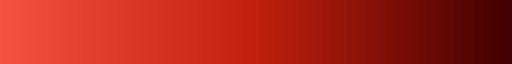

In [300]:
import random
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import colorsys

def random_medium_colormap(seed, name="random_colormap"):
    
    # Generate a random medium color in HLS space to control luminance
    hue = random.random()
    luminance = random.uniform(0.4, 0.5)  # Medium luminance
    saturation = random.uniform(0.6, 0.9)  # Fairly saturated
    r, g, b = colorsys.hls_to_rgb(hue, luminance, saturation)
    
    # Define a gradient from light to dark
    light_color = (min(1, r + 0.4), min(1, g + 0.4), min(1, b + 0.4))
    dark_color = (max(0, r - 0.4), max(0, g - 0.4), max(0, b - 0.4))
    
    # Create the colormap
    colors = [light_color, (r, g, b), dark_color]
    cmap = LinearSegmentedColormap.from_list(name, colors)
    
    return cmap

#colormap_names = ["Reds", "Blues", "Greens", "Purples", "Oranges", "Greys", "Yellows"]*50

def generate_legend_html(subspp_colors, common_name, sci_name):
    """
    Generate HTML for the legend dynamically based on subspecies and colormaps.

    Created by ChatGPT.

    Args:
    - subspp_colors: Dictionary mapping subspecies to (colormap, norm) tuples.

    Returns:
    - HTML string for the legend.
    """
    legend_html = f"""
    <div style="
        position: fixed;
        top: 10px;
        right: 10px;
        width: 150px;
        height: auto;
        z-index: 9999;
        background-color: white;
        box-shadow: 0 0 5px rgba(0, 0, 0, 0.2);
        border: 1px solid lightgray;
        border-radius: 5px;
        padding: 10px;
        font-size: 10px;
        line-height: 10px;
    ">
        <strong>{common_name} subspecies</strong><br>
    """

    for subsp, (cmap, norm) in subspp_colors.items():
        # Generate gradient for the colormap
        gradient = "background: linear-gradient(to right, "
        gradient += ", ".join(
            matplotlib.colors.to_hex(cmap(norm(v)))
            for v in [0, 0.25, 0.5, 0.75, 1]
        )
        gradient += ");"
        
        legend_html += f"""
        <div style="margin-top: 10px;">
            <span style="display: inline-block; width: 20px; height: 10px; margin-right: 10px; {gradient}"></span>
            {subsp[len(sci_name)+1:]}
        </div>
        """
    
    legend_html += "</div>"
    return legend_html

def get_bounds(geojson_result):
    """
    Calculate the bounding box of all features in the GeoJSON.

    Args:
    - geojson_result: GeoJSON string with features.

    Returns:
    - Bounds as [[southwest_lat, southwest_lon], [northeast_lat, northeast_lon]].
    """
    geojson_data = json.loads(geojson_result)
    all_coords = []

    for feature in geojson_data['features']:
        # Extract all coordinates from the polygon or multipolygon
        coords = feature['geometry']['coordinates']
        if feature['geometry']['type'] == "Polygon":
            all_coords.extend(coords[0])  # Add outer ring of the polygon
        elif feature['geometry']['type'] == "MultiPolygon":
            for poly in coords:
                all_coords.extend(poly[0])  # Add outer ring of each polygon

    # Extract longitudes (x) and latitudes (y) correctly
    lons, lats = zip(*all_coords)
    return [[min(lats), min(lons)], [max(lats), max(lons)]]

def get_color(cmap, value, norm):
    """Get a color from a colormap based on a value
    Args:
    - cmap: Colormap object
    - value: Value to get color for
    - norm: a matplotlib Normalize object to apply to the colormap

    Created by ChatGPT
    """
    rgba = cmap(norm(value))  # Get RGBA from colormap
    return matplotlib.colors.to_hex(rgba)  # Convert to HEX for Folium

def hex_to_rgb(hex_color):
    """
    Convert hex color (#RRGGBB) to an (R, G, B) tuple.

    Created by ChatGPT
    """
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb):
    """
    Convert an (R, G, B) tuple to a hex color (#RRGGBB).

    Created by ChatGPT
    """
    return "#{:02x}{:02x}{:02x}".format(*rgb)

def proportionally_combine_hex_colors(hex_colors, fracs):
    """
    Combine a list of hex colors proportionally.

    Created by ChatGPT
    """
    # Convert hex colors to RGB
    rgb_colors = [hex_to_rgb(color) for color in hex_colors]

    # Combine colors proportionally
    combined_rgb = tuple(
        sum(frac * color[channel] for color, frac in zip(rgb_colors, fracs))
        for channel in range(3)
    )
    
    final_hex = rgb_to_hex(combined_rgb)
    if final_hex == "#000000":
        return "#9e9e9e"
    return final_hex

# Style function
def style_function(feature, subspp_to_cmap):
    """Style a cell based on the proportion of subspecies.

    Created with assistance of ChatGPT and GitHub Copilot.

    Args:
    - feature: GeoJSON feature
    - subspp_to_cmap: Dictionary mapping subspecies to (colormap, norm) tuples

    Returns:
    - Style dictionary for the cell
    """

    properties = feature['properties']
    subspecies_values = {subsp: properties.get(subsp, 0) for subsp in subspp_to_cmap.keys()}
    #subspecies_colors = {subsp: get_color(cmap, subspecies_values[subsp], norm) for subsp, (cmap, norm) in subspp_to_cmap.items()}

    
    # Normalize the values to sum up to 1 for proportional allocation
    total = sum(subspecies_values.values())
    if total > 0:
        fracs = [ int(value / total) for value in subspecies_values.values()]
    else:
        fracs = [0 for value in subspecies_values.values()]

    # Get hexadecimal colors
    hex_colors = [get_color(cmap, value, norm) for value, (cmap, norm) in zip(subspecies_values.values(), subspp_to_cmap.values())]

    cell_color = proportionally_combine_hex_colors(hex_colors, fracs)

    return {
        'fillColor': cell_color, # Cell color
        'color': cell_color,  # Border color
        'weight': 0, # Border weight
        #'opacity': 0.6, # Border and cell opacity?
        'fillOpacity': 0.6, # Cell fill transparency
    }


def choropleth_map(sp_cell_df, common_name, colormap_names, initial_map = None):
    """
    Creates choropleth maps given the aggregated data. initial_map can be an existing map to draw on top of.

    Adapted from: https://jens-wirelesscar.medium.com/lhexagone-in-hexagons-uber-h3-map-1566bc412172

    Args:
    - sp_cell_df: pd.DataFrame, dataframe of species and subspecies data for each cell
    - common_name: str, common name of the species
    - colormap_names: list of str, names of colormaps for subspecies
    - initial_map: folium.Map, an existing map to draw on top of

    """    

    f = folium.Figure()
    if initial_map is None:
        initial_map = folium.Map(location= [47, -122], zoom_start=5, tiles="cartodbpositron")
    f.add_child(initial_map)

    sp = sp_cell_df.columns[0]
    subspp = sp_cell_df.columns[1:]
    subspp_colors = dict(zip(subspp, colormap_names))

    list_features = []
    #percentages = sp_cell_df.apply(lambda row: row[subspp]/row[sp], axis=1)

    # Produce a GeoJSON feature containing properties for the frequency of each subspecies for each cell
    for _, row in sp_cell_df.iterrows():
        percentages = (row[subspp]/row[sp])
        percentages_dict = percentages.to_dict()
        geometry_for_row = h3.cells_to_geo(cells=[row.name])
        feature = Feature(geometry = geometry_for_row , id=row.name, properties = percentages_dict)
        list_features.append(feature)

    feat_collection = FeatureCollection(list_features)
    geojson_result = json.dumps(feat_collection)

    # Define colormaps for subspecies
    subspp_colors = dict()
    # for subsp, cmap_name in zip(subspp, colormap_names):
    #     cmap = matplotlib.colormaps.get_cmap(cmap_name)
    for idx, subsp in enumerate(subspp):
        cmap = random_medium_colormap(seed=idx)
        vmax = 0.001#sp_cell_df[subsp].max()
        vmin = 0
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        subspp_colors[subsp] = (cmap, norm)

    # Add GeoJSON layer to the map
    folium.GeoJson(
        geojson_result,
        style_function=lambda feature: style_function(feature, subspp_colors),
        name = f'{sp} Subspecies Map'
    ).add_to(initial_map)

    # Add legend
    legend_html = generate_legend_html(subspp_colors, common_name=common_name, sci_name=sp)
    legend_element = folium.Element(legend_html)
    initial_map.get_root().html.add_child(legend_element)

    # Calculate bounds and adjust the map's view
    bounds = get_bounds(geojson_result)
    initial_map.fit_bounds(bounds)

    return initial_map


#species = "Garrulus glandarius".replace(" ", "-")
species = "Loxia curvirostra".replace(" ", "-")

common_name = taxonomy[taxonomy['SCI_NAME'] == "Loxia curvirostra"].PRIMARY_COM_NAME.values[0]
resolution = 4
sp_cell_df = pd.read_csv(f"sp_cell_dfs/{species}_resolution{resolution}.csv", index_col=0)
num_obs_per_ssp = sp_cell_df.sum()
keep_sspp = num_obs_per_ssp[num_obs_per_ssp > 0].index
sp_cell_df = sp_cell_df[keep_sspp]


m = choropleth_map(sp_cell_df, common_name=common_name, colormap_names=colormap_names)
with open(f"/Users/tessa/Code/scratchpad/subspecies_plotter/maps/{species}_{resolution}.html", "w") as f:
    m = m._repr_html_()
    f.write(m)


'Red Crossbill'